In [3]:
import numpy as np  
import pickle
from sklearn.decomposition import PCA
import gpflow

import SetPub
SetPub.set_pub()

In [4]:
def scale01(fmin, fmax, f):
    return (f - fmin) / (fmax - fmin)


def modelLoad(nRankMax, snap_ID):
    GPmodel = modelDir + 'nCorrLogfixedGP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  
    PCAmodel = modelDir + 'nCorrLogfixedPCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  

    ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
    saver = gpflow.saver.Saver()
    GPm = saver.load(GPmodel, context=ctx_for_loading)
    GPm.clear()
    GPm.compile()
    PCAm = pickle.load(open(PCAmodel, 'rb'))

    print(GPmodel)
    return GPm, PCAm

def GPy_predict(gpmodel, para_array):
    m1p = gpmodel.predict_f(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(gpmodel, pcamodel, para_array):
    para_array = np.array(para_array)
    print(para_array)
    para_array[3] = np.log10(para_array[3])
    para_array_rescaled = scale01(lhdmin, lhdmax, para_array)
    if len(para_array.shape) == 1:
        print(para_array_rescaled)
        W_predArray, _ = GPy_predict(gpmodel, np.expand_dims(para_array_rescaled, axis=0))
        x_decoded = pcamodel.inverse_transform(W_predArray)
        return np.squeeze(x_decoded)#[0]

def MGemu(Om, ns, s8, fR0, n, z):
    if (z==0):
        GPm, PCAm = modelLoad(nRankMax, 99)
        Pk_interp = Emu(GPm, PCAm, [Om, ns, s8, fR0, n])

    else:
        snap_idx_nearest = (np.abs(z_all - z)).argmin()
        if (z > z_all[snap_idx_nearest]): 
            snap_ID_z1 = snap_idx_nearest - 1    
        else:
            snap_ID_z1 = snap_idx_nearest 
        snap_ID_z2 = snap_ID_z1 + 1

        GPm1, PCAm1 = modelLoad(nRankMax, snap_ID_z1)
        Pk_z1 = Emu(GPm1, PCAm1, [Om, ns, s8, fR0, n])
        z1 = z_all[snap_ID_z1]

        GPm2, PCAm2 = modelLoad(nRankMax, snap_ID_z2)
        Pk_z2 = Emu(GPm2, PCAm2, [Om, ns, s8, fR0, n])
        z2 = z_all[snap_ID_z2]
        
        print('Linear interpolating for redshift between', 'z1= '+ str(z_all[snap_ID_z1]), 'z2= '+ str(z_all[snap_ID_z2]))
        print('Linear interpolating for snapshots ', 'for z1= '+ str(snap_ID_z1), 'and z2= '+ str(snap_ID_z2))
        
        Pk_interp = np.zeros_like(Pk_z1)
        Pk_interp = Pk_z2 + (Pk_z1 - Pk_z2)*(z - z2)/(z1 - z2)
    return Pk_interp


In [5]:

def MGemuClosest(Om, ns, s8, fR0, n, z):

    closest_idx = (np.abs(z_all - z)).argmin() 
    GPm, PCAm = modelLoad(nRankMax, closest_idx)
    Pk_interp = Emu(GPm, PCAm, [Om, ns, s8, fR0, n])

    print('Closest snap = ', closest_idx, 'at z= ', str(z_all[closest_idx]) )

    # else:
    #     snap_idx_nearest = (np.abs(z_all - z)).argmin()
    #     if (z > z_all[snap_idx_nearest]): 
    #         snap_ID_z1 = snap_idx_nearest - 1    
    #     else:
    #         snap_ID_z1 = snap_idx_nearest 
    #     snap_ID_z2 = snap_ID_z1 + 1

    #     GPm1, PCAm1 = modelLoad(nRankMax, snap_ID_z1)
    #     Pk_z1 = Emu(GPm1, PCAm1, [Om, ns, s8, fR0, n])
    #     z1 = z_all[snap_ID_z1]

    #     GPm2, PCAm2 = modelLoad(nRankMax, snap_ID_z2)
    #     Pk_z2 = Emu(GPm2, PCAm2, [Om, ns, s8, fR0, n])
    #     z2 = z_all[snap_ID_z2]
        
    #     print('Linear interpolating for redshift between', 'z1= '+ str(z_all[snap_ID_z1]), 'z2= '+ str(z_all[snap_ID_z2]))
        
    #     Pk_interp = np.zeros_like(Pk_z1)
    #     Pk_interp = Pk_z2 + (Pk_z1 - Pk_z2)*(z - z2)/(z1 - z2)
    return Pk_interp

In [6]:
nRankMax = 16
snap_ID = 61
del_idx = [5, 25, 4, 42]  ## Random holdouts (not used in training, reserved for validation) 


dataDir = "./Data/Fixedn/" ## Data folder
modelDir = "./Models/Fixedn/" ## Data folder
plotsDir = "./Plots/Fixedn/" ## Data folder

az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratiosbinsnew_' + str(99) + '.txt'

loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]
z_all = az[:, 1]

lhdmin, lhdmax = np.loadtxt(dataDir + 'paralims_nCorr.txt')

In [7]:
z_all[45]

1.124045

In [8]:
h = 0.697
Om_f=(h**2)*0.281
ns_f=0.971
s8_f=0.82
z_f= 0.0 #0.505668030951772
n_f=1
fr0_f4 = 1e-4
fr0_f5 = 1e-5
fr0_f6 = 1e-6


emu_f4= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_f)
emu_f5= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f5, n=n_f, z=z_f)
emu_f6= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f6, n=n_f, z=z_f)

import matplotlib.pylab as plt
# plt.clf()
# nbody = np.loadtxt('./Data/Nbody_validation/ratiosz05.txt', skiprows=1)
nbody = np.loadtxt('./Data/Nbody_validation/ratios_38.txt')



# plt.xlim(1e-2, 1)
# plt.show()







./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap99
[1.365e-01 9.710e-01 8.200e-01 1.000e-04 1.000e+00]
[0.472 0.605 0.6   1.    0.25 ]
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap99
[1.365e-01 9.710e-01 8.200e-01 1.000e-05 1.000e+00]
[0.472 0.605 0.6   0.75  0.25 ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap99
[1.365e-01 9.710e-01 8.200e-01 1.000e-06 1.000e+00]
[0.472 0.605 0.6   0.5   0.25 ]


In [9]:
# common_min = np.max( [np.min(kvals), np.min(nbody[:,0])] )
# common_max = np.min( [np.max(kvals), np.max(nbody[:,0])] )
#print(common_min, common_max)

In [10]:
h = 0.697
Om_f=(h**2)*0.281
ns_f=0.971
s8_f=0.82
z_f= 0.505668030951772
n_f=1
fr0_f4 = 1e-4
fr0_f5 = 1e-5
fr0_f6 = 1e-6

emu2_f4= MGemuClosest(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_f)
emu1_f4= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_f)
emu1_f5= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f5, n=n_f, z=z_f)
emu1_f6= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f6, n=n_f, z=z_f)

nbody1 = np.loadtxt('./Data/Nbody_validation/ratios_27.txt', skiprows=1)

# fig, ax = plt.subplots(1, 3, figsize = (8,6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})
# plt.subplots_adjust(wspace=0.25)

# ax[0].plot(kvals, emu_f4, 'k--', label='f4 emu z=0')

# plt.xlim(1e-2, 1)
# plt.show()

./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap65
[1.365e-01 9.710e-01 8.200e-01 1.000e-04 1.000e+00]
[0.472 0.605 0.6   1.    0.25 ]
Closest snap =  65 at z=  0.4997
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap64
[1.365e-01 9.710e-01 8.200e-01 1.000e-04 1.000e+00]
[0.472 0.605 0.6   1.    0.25 ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap65
[1.365e-01 9.710e-01 8.200e-01 1.000e-04 1.000e+00]
[0.472 0.605 0.6   1.    0.25 ]
Linear interpolating for redshift between z1= 0.52207 z2= 0.4997
Linear interpolating for snapshots  for z1= 64 and z2= 65
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap64
[1.365e-01 9.710e-01 8.200e-01 1.000e-05 1.000e+00]
[0.472 0.605 0.6   0.75  0.25 ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap65
[1.365e-01 9.710e-01 8.200e-01 1.000e-05 1.000e+00]
[0.472 0.605 0.6   0.75  0.25 ]
Linear interpolating for redshift between z1= 0.52207 z2= 0.4997
Linear interpolating for snapshots  for z1= 64 and z2= 65
./Models/Fixedn/nCorrLogfixedGP_smooth_ra

In [11]:
h = 0.697
Om_f=(h**2)*0.281
ns_f=0.971
s8_f=0.82
z_f = 0.397
n_f=1
fr0_f4 = 1e-4
fr0_f5 = 1e-5
fr0_f6 = 1e-6


emu2_f4= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_f)
emu2_f5= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f5, n=n_f, z=z_f)
emu2_f6= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f6, n=n_f, z=z_f)

GPm, PCAm = modelLoad(nRankMax, 71)
Pk70_f4 = Emu(GPm, PCAm, [Om_f, ns_f, s8_f, fr0_f4, n_f])
Pk70_f5 = Emu(GPm, PCAm, [Om_f, ns_f, s8_f, fr0_f5, n_f])
Pk70_f6 = Emu(GPm, PCAm, [Om_f, ns_f, s8_f, fr0_f6, n_f])


nbody2 = np.loadtxt('./Data/Nbody_validation/ratios_29.txt', skiprows=1)
# nbody = np.loadtxt('./Data/Nbody_validation/ratiosz0.txt')

# fig, ax = plt.subplots(2, 1, figsize = (8,6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})
# plt.subplots_adjust(wspace=0.25)



./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap70
[1.365e-01 9.710e-01 8.200e-01 1.000e-04 1.000e+00]
[0.472 0.605 0.6   1.    0.25 ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap71
[1.365e-01 9.710e-01 8.200e-01 1.000e-04 1.000e+00]
[0.472 0.605 0.6   1.    0.25 ]
Linear interpolating for redshift between z1= 0.397038 z2= 0.37817
Linear interpolating for snapshots  for z1= 70 and z2= 71
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap70
[1.365e-01 9.710e-01 8.200e-01 1.000e-05 1.000e+00]
[0.472 0.605 0.6   0.75  0.25 ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap71
[1.365e-01 9.710e-01 8.200e-01 1.000e-05 1.000e+00]
[0.472 0.605 0.6   0.75  0.25 ]
Linear interpolating for redshift between z1= 0.397038 z2= 0.37817
Linear interpolating for snapshots  for z1= 70 and z2= 71
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap70
[1.365e-01 9.710e-01 8.200e-01 1.000e-06 1.000e+00]
[0.472 0.605 0.6   0.5   0.25 ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap71
[1.365e-01 9.710e-

In [12]:
plt.show()

In [33]:
cola_val_dir = './Data/Nbody_validation/COLApks/'
sim_id = ['F4', 'F5', 'F6', 'LCDM']
z_array = [1.0165, 0.8069, 0.50557, 0.3984, 0.200981514826109, 0.10923, 0.06495, 0.0]


# for i in [0, 1, 2, 3, 4, 5, 6, 7]:

def cola_pk(snapID):

    if snapID==4: 
        F4_cola = 0
        F5_cola = 0
        F6_cola = 0

    else: 
        cola_f4 = np.loadtxt(cola_val_dir + 'P' + sim_id[0] + 'wmap_z' + str(z_array[snapID]) + '.txt')
        cola_f5 = np.loadtxt(cola_val_dir + 'P' + sim_id[1] + 'wmap_z' + str(z_array[snapID]) + '.txt')
        cola_f6 = np.loadtxt(cola_val_dir + 'P' + sim_id[2] + 'wmap_z' + str(z_array[snapID]) + '.txt')
        cola_lcdm = np.loadtxt(cola_val_dir + 'P' + sim_id[3] + 'wmap_z' + str(z_array[snapID]) + '.txt')

        F4_cola = np.array([ cola_f4[:, 0], cola_f4[:, 1]/cola_lcdm[:, 1] ])
        F5_cola = np.array([ cola_f5[:, 0], cola_f5[:, 1]/cola_lcdm[:, 1] ])
        F6_cola = np.array([ cola_f6[:, 0], cola_f6[:, 1]/cola_lcdm[:, 1] ])

    return F4_cola, F5_cola, F6_cola



f4_cola, f5_cola, f6_cola = cola_pk(7)
f4_cola2, f5_cola2, f6_cola2 = cola_pk(3)
f4_cola3, f5_cola3, f6_cola3 = cola_pk(2)

In [34]:
f4.shape

(2, 20)

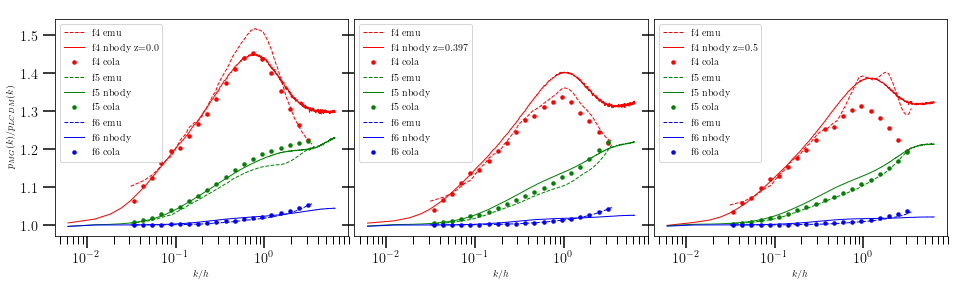

In [35]:

fig, ax = plt.subplots(1, 3, figsize = (16,4), sharey=True)
plt.subplots_adjust(wspace=0.02)

ax[0].plot(kvals, emu_f4, 'r--', label='f4 emu')
ax[0].plot(nbody[:,0], nbody[:, 1], 'r-', label='f4 nbody z=0.0')
ax[0].plot(f4_cola[0, :], f4_cola[1, :], 'r.', label='f4 cola')


ax[0].plot(kvals, emu_f5, 'g--', label='f5 emu')
ax[0].plot(nbody[:,0], nbody[:, 2], 'g-', label='f5 nbody')
ax[0].plot(f5_cola[0, :], f5_cola[1, :], 'g.', label='f5 cola')


ax[0].plot(kvals, emu_f6, 'b--', label='f6 emu')
ax[0].plot(nbody[:,0], nbody[:, 3], 'b-', label='f6 nbody')
ax[0].plot(f6_cola[0, :], f6_cola[1, :], 'b.', label='f6 cola')

ax[0].set_xscale('log')

ax[0].legend()
ax[0].set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax[0].set_xlabel(r'$k/h$')




ax[1].plot(kvals, emu2_f4, 'r--', label='f4 emu')
ax[1].plot(nbody2[:,0], nbody2[:, 1], 'r-', label='f4 nbody z=0.397')
# ax[0].plot(kvals, emu2_f4, 'rx', alpha = 0.3, label='f4 cola')
ax[1].plot(f4_cola2[0, :], f4_cola2[1, :], 'r.', label='f4 cola')



ax[1].plot(kvals, emu2_f5, 'g--', label='f5 emu')
ax[1].plot(nbody2[:,0], nbody2[:, 2], 'g-', label='f5 nbody')
# ax[0].plot(kvals, emu2_f5, 'gx', alpha = 0.3, label='f5 emu no interpolation')
ax[1].plot(f5_cola2[0, :], f5_cola2[1, :], 'g.', label='f5 cola')


ax[1].plot(kvals, emu2_f6, 'b--', label='f6 emu')
ax[1].plot(nbody2[:,0], nbody2[:, 3], 'b-', label='f6 nbody')
# ax[0].plot(kvals, emu2_f6, 'bx', alpha = 0.3, label='f6 emu no interpolation')
ax[1].plot(f6_cola2[0, :], f6_cola2[1, :], 'b.', label='f6 cola')

ax[1].set_xscale('log')

ax[1].legend()
# ax[2].set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax[1].set_xlabel(r'$k/h$')
# plt.xlim(1e-2, 1)


ax[2].plot(kvals, emu1_f4, 'r--', label='f4 emu')
# ax[0].plot(kvals, emu2_f4, 'b--', label='f4 emu nearest z=0.5')
# ax[0].plot(nbody[:,0], nbody[:, 1], 'k-', label='f4 nbody z=0')
ax[2].plot(nbody1[:,0], nbody1[:, 1], 'r-', label='f4 nbody z=0.5')
ax[2].plot(f4_cola3[0, :], f4_cola3[1, :], 'r.', label='f4 cola')


ax[2].plot(kvals, emu1_f5, 'g--', label='f5 emu')
ax[2].plot(nbody1[:,0], nbody1[:, 2], 'g-', label='f5 nbody')
ax[2].plot(f5_cola3[0, :], f5_cola3[1, :], 'g.', label='f5 cola')

ax[2].plot(kvals, emu1_f6, 'b--', label='f6 emu')
ax[2].plot(nbody1[:,0], nbody1[:, 3], 'b-', label='f6 nbody')
ax[2].plot(f6_cola3[0, :], f6_cola3[1, :], 'b.', label='f6 cola')

ax[2].set_xscale('log')

ax[2].legend()
# ax[1].set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax[2].set_xlabel(r'$k/h$')


plt.savefig('/Users/nramachandra/Desktop/Projects/Fr0/PyEmu/nbody_emu.pdf', layout='tight' )
plt.show()

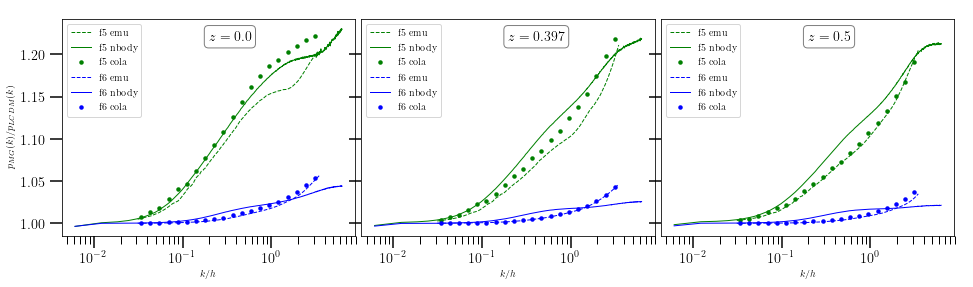

In [38]:

fig, ax = plt.subplots(1, 3, figsize = (16,4), sharey=True)
plt.subplots_adjust(wspace=0.02)

# ax[0].plot(kvals, emu_f4, 'r--', label='f4 emu')
# ax[0].plot(nbody[:,0], nbody[:, 1], 'r-', label='f4 nbody z=0.0')
# ax[0].plot(f4_cola[0, :], f4_cola[1, :], 'r.', label='f4 cola')


ax[0].plot(kvals, emu_f5, 'g--', label='f5 emu')
ax[0].plot(nbody[:,0], nbody[:, 2], 'g-', label='f5 nbody')
ax[0].plot(f5_cola[0, :], f5_cola[1, :], 'g.', label='f5 cola')


ax[0].plot(kvals, emu_f6, 'b--', label='f6 emu')
ax[0].plot(nbody[:,0], nbody[:, 3], 'b-', label='f6 nbody')
ax[0].plot(f6_cola[0, :], f6_cola[1, :], 'b.', label='f6 cola')

ax[0].set_xscale('log')

ax[0].legend()
ax[0].set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax[0].set_xlabel(r'$k/h$')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax[0].text(0.5, 0.95, r'$z=0.0$', transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)



# ax[1].plot(kvals, emu2_f4, 'r--', label='f4 emu')
# ax[1].plot(nbody2[:,0], nbody2[:, 1], 'r-', label='f4 nbody z=0.397')
# # ax[0].plot(kvals, emu2_f4, 'rx', alpha = 0.3, label='f4 cola')
# ax[1].plot(f4_cola2[0, :], f4_cola2[1, :], 'r.', label='f4 cola')



ax[1].plot(kvals, emu2_f5, 'g--', label='f5 emu')
ax[1].plot(nbody2[:,0], nbody2[:, 2], 'g-', label='f5 nbody')
# ax[0].plot(kvals, emu2_f5, 'gx', alpha = 0.3, label='f5 emu no interpolation')
ax[1].plot(f5_cola2[0, :], f5_cola2[1, :], 'g.', label='f5 cola')


ax[1].plot(kvals, emu2_f6, 'b--', label='f6 emu')
ax[1].plot(nbody2[:,0], nbody2[:, 3], 'b-', label='f6 nbody')
# ax[0].plot(kvals, emu2_f6, 'bx', alpha = 0.3, label='f6 emu no interpolation')
ax[1].plot(f6_cola2[0, :], f6_cola2[1, :], 'b.', label='f6 cola')

ax[1].set_xscale('log')

ax[1].legend()
# ax[2].set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax[1].set_xlabel(r'$k/h$')
# plt.xlim(1e-2, 1)
ax[1].text(0.5, 0.95, r'$z=0.397$', transform=ax[1].transAxes, fontsize=14, verticalalignment='top', bbox=props)


# ax[2].plot(kvals, emu1_f4, 'r--', label='f4 emu')
# # ax[0].plot(kvals, emu2_f4, 'b--', label='f4 emu nearest z=0.5')
# # ax[0].plot(nbody[:,0], nbody[:, 1], 'k-', label='f4 nbody z=0')
# ax[2].plot(nbody1[:,0], nbody1[:, 1], 'r-', label='f4 nbody z=0.5')
# ax[2].plot(f4_cola3[0, :], f4_cola3[1, :], 'r.', label='f4 cola')


ax[2].plot(kvals, emu1_f5, 'g--', label='f5 emu')
ax[2].plot(nbody1[:,0], nbody1[:, 2], 'g-', label='f5 nbody')
ax[2].plot(f5_cola3[0, :], f5_cola3[1, :], 'g.', label='f5 cola')

ax[2].plot(kvals, emu1_f6, 'b--', label='f6 emu')
ax[2].plot(nbody1[:,0], nbody1[:, 3], 'b-', label='f6 nbody')
ax[2].plot(f6_cola3[0, :], f6_cola3[1, :], 'b.', label='f6 cola')

ax[2].set_xscale('log')

ax[2].legend()
# ax[1].set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax[2].set_xlabel(r'$k/h$')

ax[2].text(0.5, 0.95, r'$z=0.5$', transform=ax[2].transAxes, fontsize=14, verticalalignment='top', bbox=props)



plt.savefig('/Users/nramachandra/Desktop/Projects/Fr0/PyEmu/nbody_emu.pdf', layout='tight' )
plt.show()